# Animal Shelter (Random Forest)


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load the Animal Shelter dataset and display a sample.

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


Also load the intake dataset downloaded from https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm so as to augment the kaggle dataset with further information about the animals.

# 1. Data Preparation


Split the "SexuponOutcome" field into "Sex" and "Neutered".

In [5]:
def splitSex(df):
    df.loc[df["SexuponOutcome"].isnull(), "SexuponOutcome"]="unknown"

    df["Sex"] = df["SexuponOutcome"].str.lower().str.contains(" male")
    df.loc[df["SexuponOutcome"].str.lower().str.contains(" male"), "Sex"] = "male"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("female"), "Sex"] = "female"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("unknown"), "Sex"] = "unknown"

    df["Neutered"] = (df["SexuponOutcome"].str.lower().str.contains("neutered")) |  (df["SexuponOutcome"].str.lower().str.contains("spayed"))
    df["Neutered"] = df["Neutered"].astype(int)
    df[["SexuponOutcome", "Sex", "Neutered"]].head()
    
splitSex(df)

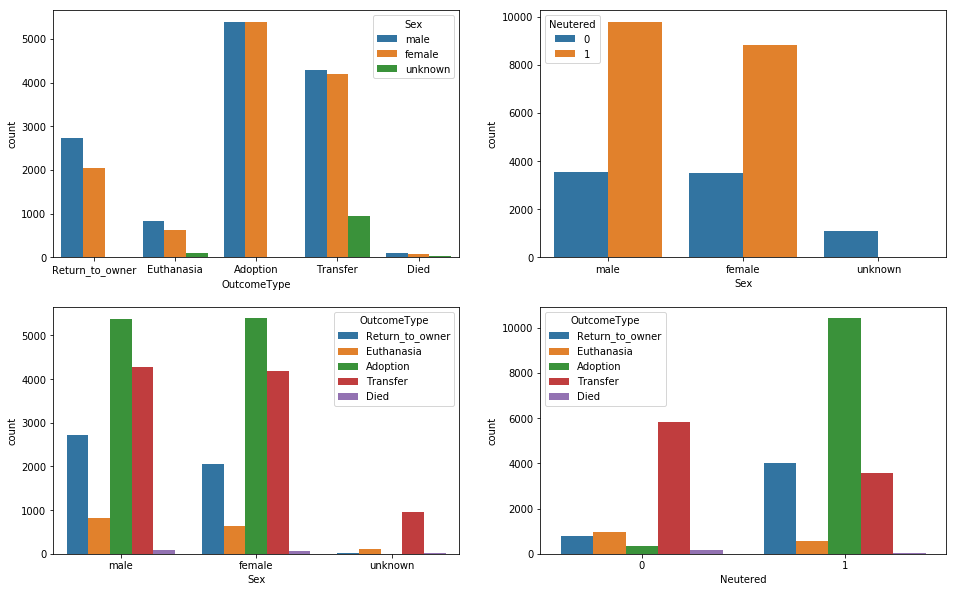

In [6]:
f, ([ax1, ax3], [ax2, ax4]) = plt.subplots(2, 2, figsize=(16, 10))
sns.countplot(data=df, x='OutcomeType',hue='Sex', ax=ax1)
sns.countplot(data=df, x='Sex',hue='OutcomeType', ax=ax2)
sns.countplot(data=df, x="Sex", hue="Neutered", ax=ax3)
sns.countplot(data=df, x="Neutered", hue="OutcomeType", ax=ax4)

Clean up breed

In [7]:
def cleanupBreed(df):
    df["PureBreed"] = ~df["Breed"].str.lower().str.contains("mix")
    df.loc[df["Breed"].str.contains("/"), "PureBreed"]=False
    df["PureBreed"] = df["PureBreed"].astype(int)
    df[["Breed", "PureBreed"]].head(10)
    
cleanupBreed(df)

Plot normalized ratios of outcomes by breed purity. Purebreed dogs are more likely to be returned to owner (not surprising), however not more likely to be adopted(surprising).

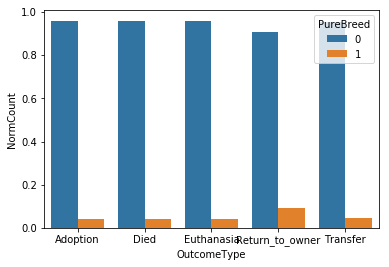

In [8]:
def normalizeCounts(df, x, sub_x, norm_over_x=False):

    agg1 = df.pivot_table(index=[x, sub_x], values=["AnimalID"], aggfunc=len)

    agg1.columns=["NormCount"]
    agg1["NormCount"] = agg1["NormCount"].astype(float)
    agg2 = df.pivot_table(index=[sub_x], values="AnimalID", aggfunc=len)
    #print agg2
    
    x_vals = agg1.index.levels[0].values
    
    #print agg1
    for x_val in x_vals:
        sub_x_vals = agg1.loc[x_val].index.unique().values
        if norm_over_x:
            tot = sum(agg1.loc[x_val, "NormCount"].values)
        
            
        for sub_x_val in sub_x_vals:
            if not norm_over_x:
                tot = agg2.loc[sub_x_val][0]
        
            val = agg1.loc[x_val].loc[sub_x_val,"NormCount"]
            val /= tot
            agg1.loc[x_val].loc[sub_x_val]=val


    agg1 = agg1.reset_index()
    #print agg1
    
    return agg1

sns.barplot(data=normalizeCounts(df, "OutcomeType", "PureBreed", norm_over_x=True), x="OutcomeType", hue="PureBreed", y="NormCount")
#sns.countplot(data=df, x="OutcomeType", hue="PureBreed")

The dog breed potentially encodes information that could improve classifier predictions, such as size of dog, breed popularity, breed temperament and longevity etc. This information, however is difficult to extract from the breed. Instead we encode the breed field into a set of features that can then be used by the classifier. The breed field is transformed into features by calculating a term-document matrix taking the rows in the Breed column as the document corpus. This results in the breed words being vectorized. 

This should allow the classifier to implicitly infer information regarding the breeds which affects the outcome. For example if chihuahuas or chihuahua mixes are unpopular for adoption, any breed mentioning chihuahua should result in a lower probability of adoption in the classifier. If medium sized breeds tend to be adopted more frequently, this should also be a correlation that emerges in the classifier. 

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.decomposition import PCA

breedsVec = TfidfVectorizer()
def preprocessBreed(df):
    #vec = CountVectorizer()
    
    breedsVec.fit(df["Breed"].str.replace("Mix", "").str.replace("/", " ").str.lower())
    
    return breedsVec
    
def processBreed(df):
    breedsTDM = breedsVec.transform(df["Breed"].str.replace("Mix", "").str.replace("/", " ").str.lower())
    print breedsTDM.shape
    
    breedsdf = pd.DataFrame(breedsTDM.toarray())
    breedCols = ["Breed_"+breedsVec.get_feature_names()[i] for i in range(0, breedsTDM.shape[1]) ]
    breedsdf.columns = breedCols
    #print breedsdf.head()

    df = df.join(breedsdf)
    #print df.head()
    return df

preprocessBreed(df)
df = processBreed(df)
df.head()

(26729, 261)


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Breed_weimaraner,Breed_welsh,Breed_west,Breed_wheaten,Breed_whippet,Breed_wire,Breed_wirehair,Breed_wirehaired,Breed_wolfhound,Breed_yorkshire
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We define a function that translates the age fields in the dataset to days by parsing the units (year(s), month(s), week(s)). We then map the age in days to an ageBracket field so as to categories the animals as (BABY, JUVENILE, ADULT, SENIOR). Animal shelters do not allow animals to be adopted before they are weaned, therefore the "BABY" bracket should add resultion to our classifier.

In [10]:
def getAgeInDays(ageStr):
    if pd.isnull(ageStr):
        return ageStr
    
    ageParts = ageStr.lower().split(" ")
    val = int(ageParts[0])
    units = ageParts[1]
    
    if units[-1:]=="s":
        units = units[0:-1]
    
    if units=="year":
        val = 365*val
    elif units=="month":
        val = 30*val
    elif units=="week":
        val = 7*val
    
    return val

def getAgeBracket(ageInDays):
    if ageInDays<=42:
        return "baby"
    elif ageInDays<=365:
        return "juvenile"
    elif ageInDays<=365*9:
        return "adult"
    else:
        return "senior"

    
def processAge(df):
    df["AgeDays"] = df["AgeuponOutcome"].apply(getAgeInDays)
    meanAge = df[["AgeDays"]].mean()

    df.loc[df["AgeDays"].isnull(), "AgeDays"]=meanAge[0]
    df["AgeBracket"] = df["AgeDays"].apply(getAgeBracket)
    
    
processAge(df)


A quick histogram of age distribution shows that most animals at the shelter are younger than about 2 years of age.

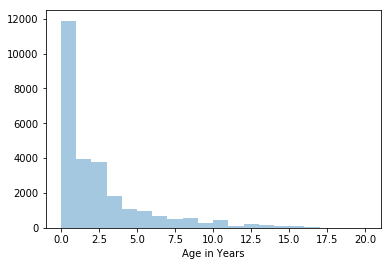

In [11]:

sns.distplot(df.AgeDays/365, bins = 20, kde=False, axlabel="Age in Years")

Visualising outcomes based on these age categories reveals, unsurprisingly, that juveniles are more likely to be adopted (or transferred) than any other age bracket. Babies are less likely to be adopted as shelters usually don't allow them to until they are weaned and are also the most likely to die. Interestingly senior dogs are more likely to be returned to their owner. These facts should have explanatory value in our model.

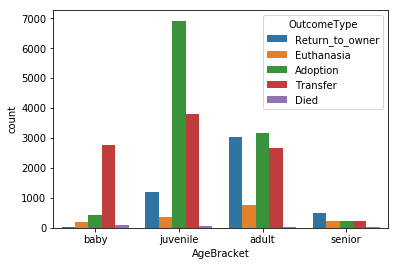

In [12]:


sns.countplot(data=df, x="AgeBracket", hue="OutcomeType", order=["baby", "juvenile", "adult", "senior"])

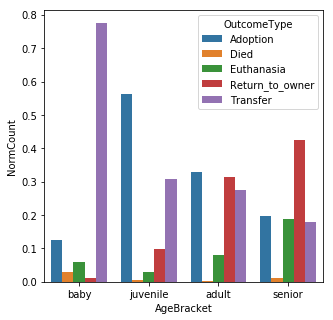

In [13]:
# Generate distribution of dog sizes grouped by outcome, normalized over outcome.
f, ax1 = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(data=normalizeCounts(df, "AgeBracket", "OutcomeType", norm_over_x=True), x="AgeBracket", hue="OutcomeType", y="NormCount", order=["baby", "juvenile", "adult", "senior"])



Here we also take the DateTime column and we split the day into 3 hour segments. This should tell us the most likely time of day for an outcome. It looks like most adoptions as well as most transfers occur during the afternoon and early evening, peaking around 15:00.

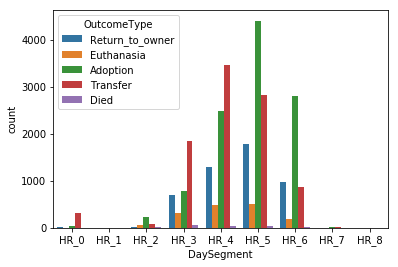

In [14]:
def tsToDaySegment(ts):
    return "HR_"+str(int(ts.hour/3))
    
def processDate(df):
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    df["DaySegment"] = df["DateTime"].apply(tsToDaySegment)
    df["OutcomeDay"] = df["DateTime"].dt.day
    df["OutcomeMonth"] = df["DateTime"].dt.month
#    df["OutcomeHour"] = df["DateTime"].dt.hour
    
processDate(df)

sns.countplot(data=df, x="DaySegment", hue="OutcomeType", order=["HR_0", "HR_1", "HR_2", "HR_3", "HR_4", "HR_5", "HR_6", "HR_7", "HR_8"])

Does the day of the week make a difference to the outcomes? 

It looks like adoptions are much more likely during the weekend.

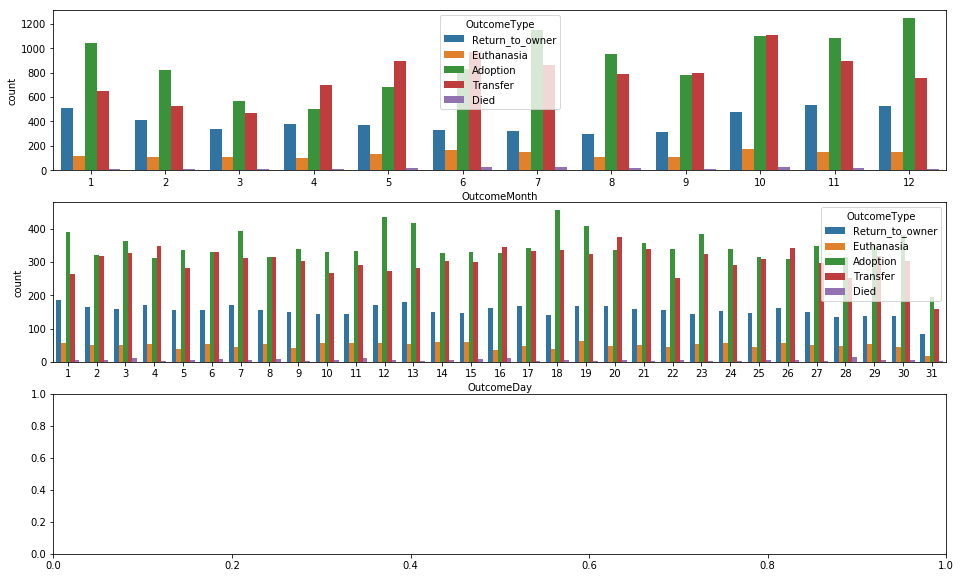

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10))
sns.countplot(data=df, x="OutcomeMonth", hue="OutcomeType", ax=ax1)
sns.countplot(data=df, x="OutcomeDay", hue="OutcomeType", ax=ax2)
#sns.countplot(data=df, x="OutcomeHour", hue="OutcomeType", ax=ax3)
plt.show()

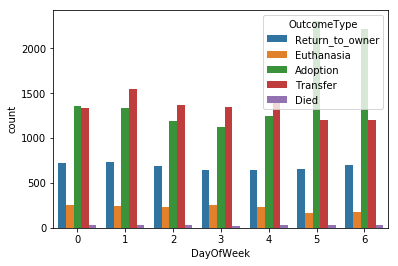

In [16]:
weekdist = pd.DataFrame(data=df[["DateTime", "OutcomeType"]])
weekdist["DayOfWeek"] = weekdist["DateTime"].apply(lambda ts: ts.weekday())

sns.countplot(data=weekdist, x="DayOfWeek", hue="OutcomeType")

In order to capture this information we create a new "IsWeekend" field in our dataset.

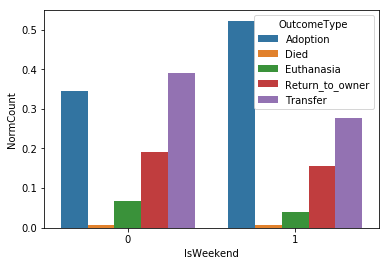

In [17]:
def processWeekend(df):
    df["IsWeekend"] = df["DateTime"].apply(lambda ts: (ts.weekday()>=5))
    df["IsWeekend"] = df["IsWeekend"].astype(int)
#sns.countplot(data=df, x="IsWeekend", hue="OutcomeType")


processWeekend(df)
sns.barplot(data=normalizeCounts(df, "IsWeekend", "OutcomeType", norm_over_x=True), x="IsWeekend", hue="OutcomeType", y="NormCount")

Does having a name make a difference to the outcome? Yes. Having a name is much more likely to result in adoption and/or return to owner.

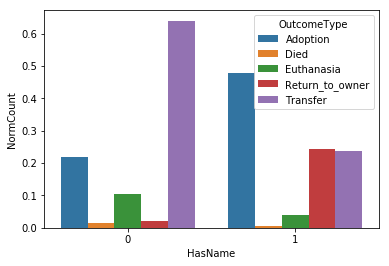

In [18]:
def processName(df):
    df["HasName"] = ~df["Name"].isnull()
    df["HasName"] = df["HasName"].astype(int)


processName(df)

#sns.countplot(data=df, x="HasName", hue="OutcomeType")
sns.barplot(data=normalizeCounts(df, "HasName", "OutcomeType", norm_over_x=True), x="HasName", hue="OutcomeType", y="NormCount")

We also need to simplify the color field. There are too many unique colors. We do this by splitting on "/" or " " and taking only the first word.

In [19]:
df["Color"].unique().size

366

In [20]:
colorsVec = TfidfVectorizer()

def preprocessColor(df):
    #vec = CountVectorizer()
    #colorsVec = TfidfVectorizer()
    colorsVec.fit(df["Color"].str.lower())
    
    return colorsVec
    
def processColor2(df):
    colorsTDM = colorsVec.transform(df["Color"].str.lower())
    print colorsTDM.shape
    
    colorsdf = pd.DataFrame(colorsTDM.toarray())
    colorsCols = ["Color_"+colorsVec.get_feature_names()[i] for i in range(0, colorsTDM.shape[1]) ]
    colorsdf.columns = colorsCols
    #print breedsdf.head()

    df = df.join(colorsdf)
    #print df.head()
    return df

preprocessColor(df)
df = processColor2(df)
df.head()

(26729, 36)


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Color_smoke,Color_tabby,Color_tan,Color_tick,Color_tiger,Color_torbie,Color_tortie,Color_tricolor,Color_white,Color_yellow
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.599352,0.0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0.0,0.483679,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.461802,0.0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


How balanced or unbalanced are our classes?

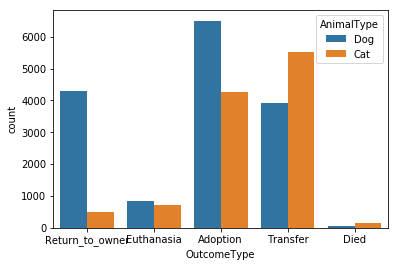

In [21]:
sns.countplot(data=df, x="OutcomeType", hue="AnimalType")

It is clear that there is a severe inbalance in the prediction classes.

The simplest solution is to duplicate records in the minority classes, however experiments with this approach resulted in a worse classifier performance.

Instead we use SMOTE (further down) which empirically gives much better results.

In [22]:
#outcomeCounts = df.pivot_table(index=["OutcomeType"], values=["AnimalID"], aggfunc=len)
#
#maxOutcomeCount = np.max(outcomeCounts.values.ravel())
#
#outcomes = df["OutcomeType"].unique()
#
##newrecords = pd.DataFrame(columns=df.columns)
#
#newrecords = pd.DataFrame.from_items(
#    [(name, pd.Series(data=None, dtype=series.dtype)) for name, series in df.iteritems()])
#
#for outcome in outcomes:
#    outcomeCount = outcomeCounts.loc[outcome].values[0]
#    diff = maxOutcomeCount - outcomeCount
#    
#    if diff > 0:
#        subset = pd.DataFrame(df.loc[df["OutcomeType"]==outcome,:])
#        subset = subset.iloc[np.random.randint(0, subset.index.size, size=diff)]
#        print outcome, ": added ", subset.index.size, " records"
#        newrecords = newrecords.append(subset)
#        
#print "Total records added: ", newrecords.index.size

#df = df.append(newrecords)

#sns.countplot(data=df, x="OutcomeType")

# Machine Learning Model

Prepare the dataset for learning

N.B. We will treat OutcomeType as the dependant variable. OutcomeType is directly inferable from OutcomeSubtype, however this goes contrary to the spirit of the Kaggle challenge and the Kaggle testing set does not include this field among the features, therefore in order for our learning algorithm not to be trivial, we will remove this field.

In [23]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Color_smoke,Color_tabby,Color_tan,Color_tick,Color_tiger,Color_torbie,Color_tortie,Color_tricolor,Color_white,Color_yellow
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.599352,0.0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0.0,0.483679,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.461802,0.0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


Select only the fields we need for learning.

In [24]:
# Experimentally reduce problem to a binary lives/dies classification
def reduceOutcome(outcome):
    return outcome in ("Adoption", "Return_to_owner", "Transfer")

# reduce outcome classes to lives/dies
def prepareOutcome(df):
    df["OutcomeTypeReduced"]=df["OutcomeType"].apply(reduceOutcome)
    
#prepareOutcome(df)

print df.head()
prepared_df = df.copy()
prepared_df = prepared_df.drop(["AnimalID", "Name", "DateTime", "OutcomeSubtype", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"], axis=1)

print prepared_df.head()


  AnimalID     Name            DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone 2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily 2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce 2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN 2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN 2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color      ...      Color_smoke  Color_tabby  Color_tan  Color_tick  \
0  Brown/White    

Pre-process our fields to make them suitable for passing to a machine learning algorithm.

In [25]:
from sklearn import preprocessing
# Need to install sklearn_pandas for DataFrameMapper. This is more flexible than sklearn pipeline
# because it can perform separate operations on different columns of the dataframe.
# pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([
    #('OutcomeType', None), #preprocessing.LabelEncoder()),
     ("AnimalType", preprocessing.LabelBinarizer()),
     ("Sex", preprocessing.LabelBinarizer()),
     ("Neutered", preprocessing.LabelBinarizer()),
     ("PureBreed", preprocessing.LabelBinarizer()),
     #("Size", preprocessing.LabelBinarizer()),
     ("AgeBracket", preprocessing.LabelBinarizer()),
     ("DaySegment", preprocessing.LabelBinarizer()),
     ("IsWeekend", preprocessing.LabelBinarizer()),
     ("HasName", preprocessing.LabelBinarizer()),
     #("SimpleColor", None),
#     ("Intake Type", preprocessing.LabelBinarizer()),
#     ("Intake Condition", preprocessing.LabelBinarizer())
], default=None, df_out=True)

labelMapper = DataFrameMapper([
    ("OutcomeType", preprocessing.LabelEncoder()),
#    ("OutcomeTypeReduced", preprocessing.LabelEncoder())
], df_out=True)




In [26]:

classes_array = labelMapper.fit_transform(prepared_df)

prepared_fitted_df = mapper.fit_transform(prepared_df)

# Drop redundant columns to avoid the Dummy Variable Trap
prepared_fitted_df = prepared_fitted_df.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "OutcomeType" ], axis=1) #"SimpleColor", "DaySegment_HR_7", 

# Create features array for learning
features_array = prepared_fitted_df.values 

print prepared_fitted_df.columns
    
print classes_array.head()

prepared_fitted_df.head()
#prepared_fitted_df.to_csv("temp.csv")

Index([         u'AnimalType',          u'Sex_female',            u'Sex_male',
                  u'Neutered',           u'PureBreed',    u'AgeBracket_adult',
           u'AgeBracket_baby', u'AgeBracket_juvenile',     u'DaySegment_HR_0',
           u'DaySegment_HR_1',
       ...
               u'Color_smoke',         u'Color_tabby',           u'Color_tan',
                u'Color_tick',         u'Color_tiger',        u'Color_torbie',
              u'Color_tortie',      u'Color_tricolor',         u'Color_white',
              u'Color_yellow'],
      dtype='object', length=317)
   OutcomeType
0            3
1            2
2            0
3            4
4            4


,AnimalType,Sex_female,Sex_male,Neutered,PureBreed,AgeBracket_adult,AgeBracket_baby,AgeBracket_juvenile,DaySegment_HR_0,DaySegment_HR_1,...,Color_smoke,Color_tabby,Color_tan,Color_tick,Color_tiger,Color_torbie,Color_tortie,Color_tricolor,Color_white,Color_yellow
0,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0.599352,0
1,0,1,0,1,0,0,0,1,0,0,...,0,0.483679,0,0,0,0,0,0,0,0
2,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.461802,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [27]:
#['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']

for c in range(0,5):
    print len(classes_array.loc[classes_array["OutcomeType"]==c])

10769
197
1555
4786
9422


Supersample the data using the SMOTE algorithm so as to mitigate the problem of class imbalance.

In [28]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

#sm = SMOTE(random_state=42, n_jobs=4, ratio={1:500})
#ss_features, ss_classes = sm.fit_sample(features_array, classes_array)
ss_features = features_array
ss_classes = classes_array.values

binarizer = preprocessing.LabelBinarizer()
#ss_classes = binarizer.fit_transform(ss_classes)
X_train, X_test, y_train, y_test = train_test_split(features_array, classes_array.values, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42, n_jobs=4, kind="borderline1")
X_train, y_train = sm.fit_sample(X_train, y_train)
y_train = np.array(y_train)[np.newaxis].T
print features_array.shape
print classes_array.shape
print X_train.shape
print y_train.shape

X_test_pre_red = X_test


/home/etienne/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(26729, 317)
(26729, 1)
(37550, 317)
(37550, 1)


In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plotROCCurves(classes, classlabels, y_test_bin, y_test_proba):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(0, len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    f, plts = plt.subplots(3, 2, figsize=(10, 10))

    plts = plts.ravel()
    lw = 2

    #classlabels=labelMapper.features[0][1].inverse_transform(classes)

    for cls in range(0, len(plts)):#range(0, clf2.n_classes_):
        #plt.subplot(3,2,cls+1)
        if (cls < len(classes)):
            plts[cls].plot(fpr[cls], tpr[cls], color='darkorange',
                     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
            plts[cls].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plts[cls].set_xlim([0.0, 1.0])
            plts[cls].set_ylim([0.0, 1.05])
            plts[cls].set_xlabel('False Positive Rate')
            plts[cls].set_ylabel('True Positive Rate')
            plts[cls].set_title('ROC curve - '+classlabels[cls]+"(AUC = " + str(round(roc_auc[cls], 2))+ ")")
            plt.legend(loc="lower right")
        else:
            plts[cls].axis("off")

    f.subplots_adjust(hspace=0.4)
    plt.show()
    


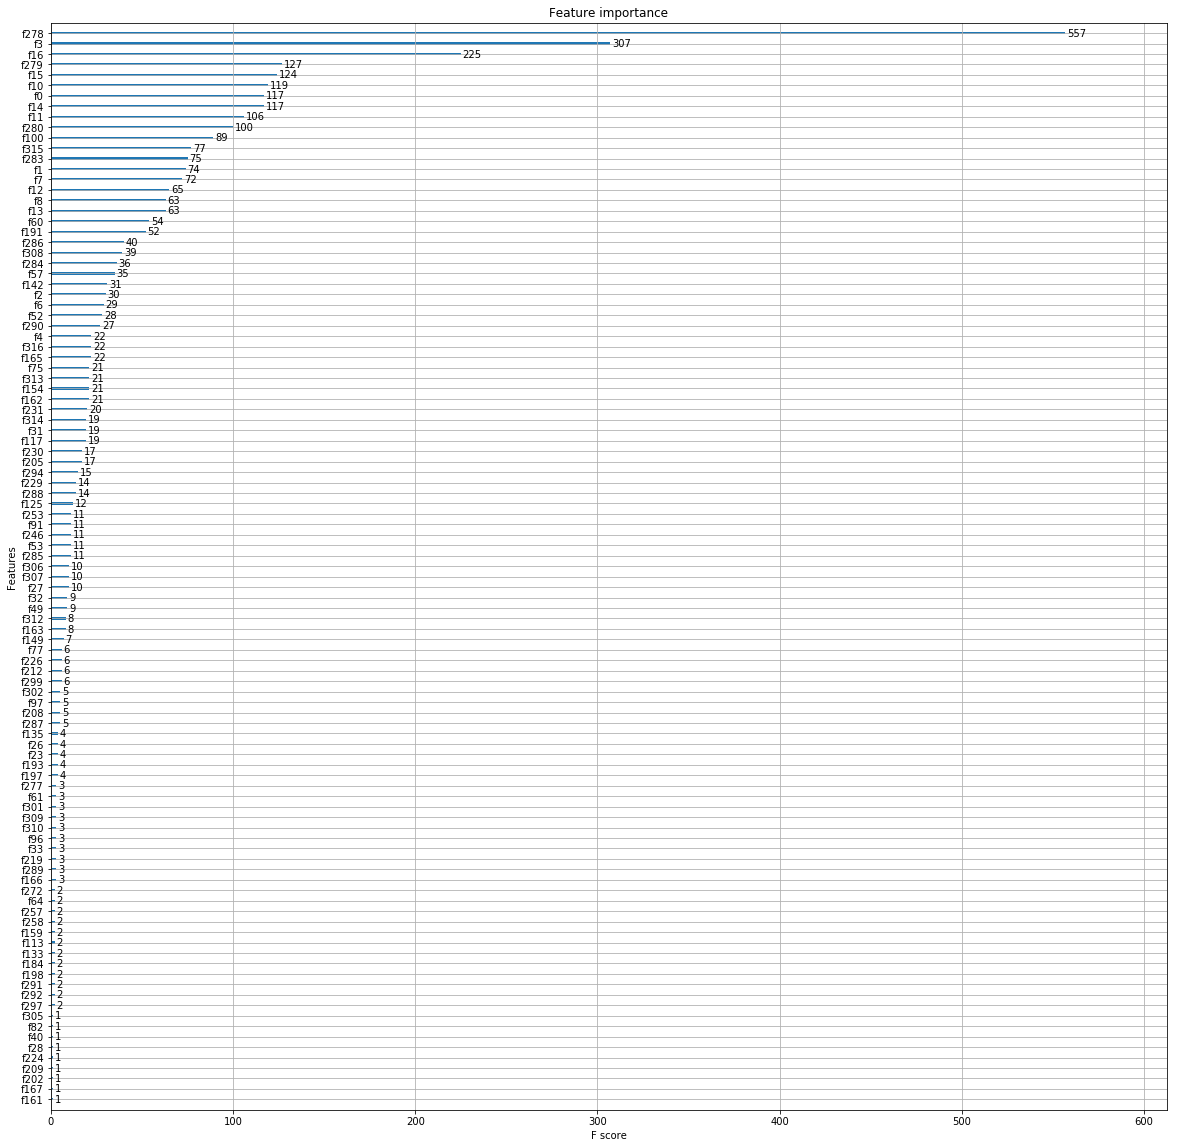

1.0
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        

In [30]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

fselGB = xgb.XGBClassifier(n_jobs=4)

fselGB.fit(X_train, y_train[:,0])

#plt.bar(range(len(GB.feature_importances_)), GB.feature_importances_)
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(fselGB, ax=ax)
plt.show()
print np.sum(fselGB.feature_importances_)
print np.sort(fselGB.feature_importances_)

thresholds_for_test = np.geomspace(0.00001, 0.1, 10, endpoint=True)
f1scores=[]
loglosses=[]
paramsleft=[]
for thresh in thresholds_for_test:
    support = fselGB.feature_importances_>thresh
    print "Threshold=", thresh, ": Re-fitting with ", np.sum(support), " features instead of ", len(support)
    
    GB2 = xgb.XGBClassifier(n_jobs=4)

    GB2.fit(X_train[:,support], y_train[:,0])

    preds = GB2.predict(np.hstack((X_test, y_test[:,1:]))[:,support])
    proba = GB2.predict_proba(np.hstack((X_test, y_test[:,1:]))[:,support])

    f1score = f1_score(y_test[:,0:1], preds, average="weighted")
    logloss = log_loss(y_test[:,0:1], proba, labels=GB2.classes_)
    print "f1 score=", f1score
    print "log loss=", logloss

    f1scores.append(f1score)
    loglosses.append(logloss)
    paramsleft.append(np.sum(support))
    
xgbresults = [thresholds_for_test, paramsleft, f1scores, loglosses]
print xgbresults
#y_test_bin = label_binarize(y_test, GB2.classes_)
#print y_test_bin
#print proba


In [34]:
xgbresults = [thresholds_for_test, paramsleft, f1scores, loglosses]
print xgbresults

[array([  1.00000000e-05,   2.78255940e-05,   7.74263683e-05,
         2.15443469e-04,   5.99484250e-04,   1.66810054e-03,
         4.64158883e-03,   1.29154967e-02,   3.59381366e-02,
         1.00000000e-01]), [103, 103, 103, 103, 82, 63, 42, 20, 5, 1], [0.65663082359247238, 0.65663082359247238, 0.65663082359247238, 0.65663082359247238, 0.65732760221674114, 0.66035930861900105, 0.65942003334519128, 0.65602964358108917, 0.59856285053618685, 0.3981501900024263], [0.83592539384272657, 0.83592539384272657, 0.83592539384272657, 0.83592539384272657, 0.83545787755712586, 0.83464488495907319, 0.83612670094352703, 0.83786578584856819, 0.94996188041475449, 1.2875392571540414]]


In [36]:
X_train.shape

(37550, 63)

[  1.00000000e-05   2.78255940e-05   7.74263683e-05   2.15443469e-04
   5.99484250e-04   1.66810054e-03   4.64158883e-03   1.29154967e-02
   3.59381366e-02   1.00000000e-01]
[0.65663082359247238, 0.65663082359247238, 0.65663082359247238, 0.65663082359247238, 0.65732760221674114, 0.66035930861900105, 0.65942003334519128, 0.65602964358108917, 0.59856285053618685, 0.3981501900024263]
[0.83592539384272657, 0.83592539384272657, 0.83592539384272657, 0.83592539384272657, 0.83545787755712586, 0.83464488495907319, 0.83612670094352703, 0.83786578584856819, 0.94996188041475449, 1.2875392571540414]
Will use threshold  0.0016681005372
[ True  True  True  True  True False  True  True  True False  True  True
  True  True  True  True  True False False False False False False False
 False False False  True False False False  True  True False False False
 False False False False False False False False False False False False
 False  True False False  True  True False False False  True False False
  Tru

IndexError: boolean index did not match indexed array along dimension 1; dimension is 63 but corresponding boolean dimension is 317

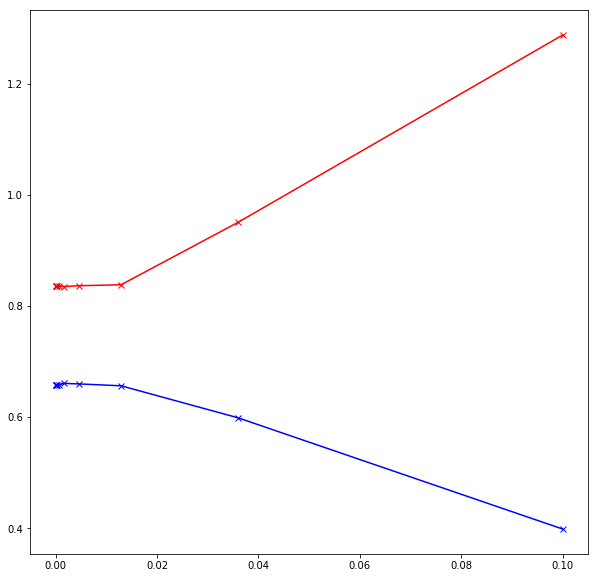

In [35]:
print thresholds_for_test
print f1scores
print loglosses

f, ax = plt.subplots(1, figsize=(10,10))
plt.plot(thresholds_for_test, f1scores, "bx-", thresholds_for_test, loglosses, "rx-")

f1_thresh = np.argsort(f1scores)[-1]
ll_thresh = np.argsort(loglosses)[0]

final_threshold = np.average((thresholds_for_test[f1_thresh], thresholds_for_test[ll_thresh]))
final_support = fselGB.feature_importances_>=final_threshold

print "Will use threshold ", final_threshold
print final_support

X_train = X_train[:,final_support]
X_test = np.hstack((X_test, y_test[:,1:]))[:,final_support]


#print prepared_fitted_df.columns[final_support[0:-1]]


In [38]:
sortedIndexes = np.argsort(fselGB.feature_importances_)[::-1]
colnames= prepared_fitted_df.columns.values
#colnames = np.append(colnames, "SimpleOutcome")

print colnames[sortedIndexes][final_support[sortedIndexes]]

['AgeDays' 'Neutered' 'HasName' 'OutcomeDay' 'IsWeekend' 'DaySegment_HR_2'
 'DaySegment_HR_6' 'AnimalType' 'DaySegment_HR_3' 'OutcomeMonth'
 u'Breed_domestic' u'Color_white' u'Color_black' 'Sex_female'
 'AgeBracket_juvenile' 'DaySegment_HR_4' 'DaySegment_HR_5'
 'DaySegment_HR_0' u'Breed_bull' u'Breed_pit' u'Color_brown' u'Color_tabby'
 u'Color_blue' u'Breed_brittany' u'Breed_jack' 'Sex_male' 'AgeBracket_baby'
 u'Breed_boston' u'Color_cream' u'Breed_miniature' 'PureBreed'
 u'Color_yellow' u'Color_tortie' u'Breed_mastiff' u'Breed_chihuahua'
 u'Breed_longhair' u'Breed_siamese' u'Breed_german' u'Color_tricolor'
 u'Breed_basset' u'Breed_rat' u'Breed_shorthair' u'Color_gray'
 u'Breed_shih' u'Color_calico' u'Breed_hair' u'Breed_boxer'
 u'Breed_staffordshire' u'Breed_terrier' u'Color_brindle'
 u'Breed_dachshund' u'Color_smoke' u'Color_silver' u'Breed_argentino'
 u'Breed_bordeaux' u'Breed_bay' u'Color_torbie' u'Breed_medium'
 u'Breed_labrador' u'Color_orange' u'Breed_rottweiler' u'Breed_shepher

In [48]:
import xgboost as xgb
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import StratifiedKFold
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from evolutionary_search import EvolutionaryAlgorithmSearchCV

n_iter = 100
k_fold = 3
  
cv = StratifiedKFold(y_train[:,0],n_folds=k_fold,shuffle=True)
  
# initialize the classifier
GB = xgb.XGBClassifier()
  
param_grid = {'max_depth': [500],
              'learning_rate': np.arange(0.1, 2.0, 20),
              'objective':['multi:softprob'],
              'n_jobs': [2],
              'missing': [np.nan],
              'reg_alpha': np.geomspace(0.01, 100, 30, endpoint=True),
              'colsample_bytree': np.arange(0.1, 1.0, 10),
              'colsample_bylevel': np.arange(0.1, 1.0, 10),
              'subsample': np.arange(0.1, 1.0, 10),
              'n_estimators': np.arange(50, 500, 10)}
  


search_GB = EvolutionaryAlgorithmSearchCV(estimator=GB,
                                   params=param_grid,
                                   scoring="neg_log_loss",
                                   cv=cv,
                                   verbose=10,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=3)

search_GB.fit(X_train,y_train[:,0])
#search_GB = RandomizedSearchCV(GB,param_grid,scoring='neg_log_loss', n_iter=n_iter,cv=cv,verbose=10, n_jobs=2).fit(X_train,y_train[:,0])
print ' ',search_GB.best_score_
print ' ',search_GB.best_params_

Types [1, 2, 2, 1, 2, 2, 1, 2, 2, 1] and maxint [44, 0, 29, 0, 0, 0, 0, 0, 0, 0] detected


/home/etienne/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/etienne/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


--- Evolve in 1350 possible combinations ---
[CV] reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=220, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=300, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=430, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=220, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.799885770139, total=  36.5s
[CV] reg_alpha=1.61026202756, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=220, subsample=0.1,

[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=410, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=270, subsample=0.1, objective=multi:softprob, max_depth=500, score=-1.34983173128, total=  29.5s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=270, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=360, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.868352178171, total=  46.2s
[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=360, subsample=0.1, objective=multi:softprob, m

[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=450, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=280, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.799868678714, total=  36.0s
[CV] reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=280, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=220, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.754018860723, total=  31.7s
[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:so

[CV] reg_alpha=1.17210229753, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=290, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=340, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.69117479925, total=  48.7s
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=340, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.65542344669, total= 1.1min
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, obje

[CV] reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=410, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=72.7895384398, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=140, subsample=0.1, objective=multi:softprob, max_depth=500, score=-1.3525770314, total=  16.1s
[CV] reg_alpha=72.7895384398, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=140, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=72.7895384398, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=140, subsample=0.1, objective=multi:softprob, max_depth=500, score=-1.36467258651, total=  16.2s
[CV] reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=300, subsample=0.1, objective=

[CV] reg_alpha=14.8735210729, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=470, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=420, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.666584565491, total= 1.0min
[CV] reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=420, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.329034456231, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=270, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.726448272393, total=  36.9s
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=90, subsample=0.1, object

[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.025929437974, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.646440878112, total= 1.1min
[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=310, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=370, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.94817459605, total=  42.7s
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=370, subsample=0.1, objectiv

[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=280, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.701003626771, total=  26.6s
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=280, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=280, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.712249927057, total=  26.9s
[CV] reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=90, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=10.8263673387, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=90, subsample=0.1, objec

[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=290, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=260, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.815035906999, total=  34.4s
[CV] reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=260, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=430, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.665836367369, total=  59.2s
[CV] reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=350, subsample=0.1, object

[CV]  reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=420, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.728527154874, total=  46.0s
[CV] reg_alpha=2.21221629107, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=420, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.853167852417, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=410, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.68793188138, total=  57.2s
[CV] reg_alpha=0.853167852417, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=410, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0489390091848, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=280, subsample=0.1, object

[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=420, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=460, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.658658298974, total= 1.1min
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=460, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=460, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.670886919102, total= 1.1min
[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=460, subsample=0.1, objective=mu

[CV]  reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=430, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.669183628044, total=  59.7s
[CV] reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=430, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.666532966857, total= 1.1min
[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, o

[CV] reg_alpha=0.126896100317, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=410, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.65542344669, total= 1.1min
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=460, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.658658298974, total= 1.1min
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=460, subsample=0.1, ob

[CV]  reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=430, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.669183628044, total=  59.9s
[CV] reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=430, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=410, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.682298077759, total=  58.2s
[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=410, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, o

[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV] reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500 
2  	20    	-0.668005	-0.746843	-0.648057	0.0231036
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.658948651242, total=  58.6s
[CV] reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, sub

[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=450, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=430, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.669183628044, total=  58.5s
[CV] reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=430, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.658948651242, total= 1.2min
[CV] reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=m

[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.655061752339, total= 1.2min
[CV] reg_alpha=0.17433288222, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=460, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.65345412744, total= 1.1min
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=460, subsample=0.1, objec

[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.645823031323, total= 1.2min
[CV] reg_alpha=0.239502661999, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=430, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.66008265662, total=  58.9s
[CV] reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=460, subsample=0.1, obje

[CV]  reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.650117940525, total= 1.1min
[CV] reg_alpha=0.0923670857187, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.646535786649, total= 1.1min
[CV] reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.067233575365, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, 

[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.638840324868, total= 1.1min
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.648967058063, total= 1.1min
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, 

[CV]  reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=460, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.652723630755, total= 1.1min
[CV] reg_alpha=0.0137382379588, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=460, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.65062295879, total= 1.1min
[CV] reg_alpha=4.17531893656, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, ob

[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.647994710759, total= 1.2min
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.653485250092, total=  59.0s
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, 

[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.65542344669, total= 1.1min
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.904879606388, total=  54.0s
[CV] reg_alpha=20.4335971786, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0356224789026, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, obje

[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=480, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.63735113293, total=  58.2s
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500 
[CV]  reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, objective=multi:softprob, max_depth=500, score=-0.653485250092, total= 1.2min
[CV] reg_alpha=0.0188739182214, n_jobs=2, colsample_bytree=0.1, missing=nan, learning_rate=0.1, colsample_bylevel=0.1, n_estimators=490, subsample=0.1, o

In [44]:
from numpy import nan
from numpy import loadtxt
from numpy import sort
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

#params={'reg_alpha': 31.6227766, 'n_jobs': 2, 'colsample_bytree': 0.92004019236052659, 'missing': nan, 'learning_rate': 0.45372879619918061, 'n_estimators': 172, 'subsample': 0.4933391563450169, 'objective': 'multi:softprob', 'max_depth': 43}
#params={'reg_alpha': 5.62341325, 'n_jobs': 2, 'colsample_bytree': 0.52605500347528933, 'missing': nan, 'learning_rate': 0.064258457713594841, 'n_estimators': 140, 'subsample': 0.98851834712965414, 'objective': 'multi:softprob', 'max_depth': 8}
#params={'reg_alpha': 0.26826957952797248, 'n_jobs': 2, 'colsample_bytree': 0.48923015934746311, 'missing': nan, 'learning_rate': 0.6550359822797861, 'n_estimators': 67, 'subsample': 0.97882979580504648, 'objective': 'multi:softprob', 'max_depth': 74}
params={'reg_alpha': 1.9306977288832496, 'n_jobs': 2, 'colsample_bytree': 0.35862752851284113, 'missing': nan, 'learning_rate': 0.051634873902333678, 'n_estimators': 380, 'subsample': 0.76031413429698103, 'objective': 'multi:softprob', 'max_depth': 34}
#params=  {'reg_alpha': 0.01, 'n_jobs': 2, 'colsample_bytree': 0.10000000000000001, 'missing': nan, 'learning_rate': 0.10000000000000001, 'colsample_bylevel': 0.10000000000000001, 'n_estimators': 490, 'subsample': 0.10000000000000001, 'objective': 'multi:softprob', 'max_depth': 500}

GB = xgb.XGBClassifier(**params)#**search_GB.best_params_)
#GB = xgb.XGBClassifier(**search_GB.best_params_)
#GB.fit(X_train, y_train)
#
#thresholds = sort(GB.feature_importances_)
#for thresh in thresholds:
#    # select features using threshold
#    selection = SelectFromModel(GB, threshold=thresh, prefit=True)
#    select_X_train = selection.transform(X_train)
#    # train model
#    selection_model = XGBClassifier()
#    selection_model.fit(select_X_train, y_train)
#    # eval model
#    select_X_test = selection.transform(X_test)
#    y_pred = selection_model.predict(select_X_test)
#    predictions = [round(value) for value in y_pred]
#    accuracy = accuracy_score(y_test, predictions)
#    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
GB.fit(X_train, y_train[:,0])

#prepreds = preclf.predict(X_test_pre_red)
#prepreds = np.reshape(prepreds, (len(prepreds), 1))
#print prepreds
#print X_test_pre_red.shape
#preds = GB.predict(np.hstack((X_test_pre_red, prepreds))[:,final_support])#X_test)
#proba = GB.predict_proba(np.hstack((X_test_pre_red, prepreds))[:,final_support])#X_test)

preds = GB.predict(X_test_pre_red[:,final_support])#X_test)
proba = GB.predict_proba(X_test_pre_red[:,final_support])#X_test)

print preds
print proba


[3 4 4 ..., 4 4 3]
[[  1.59970149e-01   2.42024986e-03   1.88856408e-01   4.44118917e-01
    2.04634234e-01]
 [  3.21409643e-01   1.84806122e-03   5.39672049e-03   1.50311962e-02
    6.56314373e-01]
 [  4.09788173e-03   5.06934430e-03   5.44791669e-02   3.06791882e-03
    9.33285713e-01]
 ..., 
 [  7.52785504e-02   9.02439642e-04   2.11714651e-03   2.25557536e-02
    8.99146140e-01]
 [  7.36444369e-02   1.23246918e-02   6.42186031e-02   2.02421565e-02
    8.29570115e-01]
 [  1.90367058e-01   1.14171871e-03   2.65427589e-01   4.56022948e-01
    8.70406404e-02]]


In [45]:

from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

f1score = f1_score(y_test, preds, average="micro")
logloss = log_loss(y_test, proba, labels=GB.classes_)
print "f1 score=", f1score
print "log loss=", logloss



f1 score= 0.67502182317
log loss= 0.791726710958


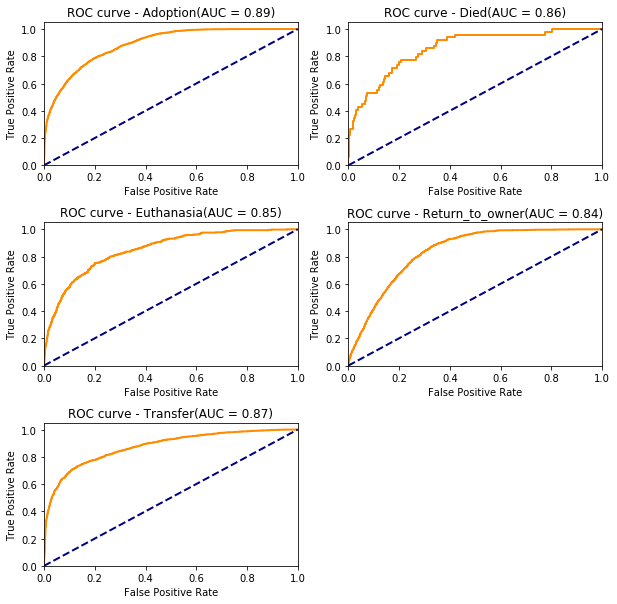

In [46]:
y_test_bin = label_binarize(y_test[:,0], GB.classes_)
plotROCCurves(GB.classes_, labelMapper.features[0][1].inverse_transform(GB.classes_), y_test_bin, proba)

In [47]:
from sklearn.metrics import confusion_matrix
print labelMapper.features[0][1].inverse_transform(GB.classes_)
cm = confusion_matrix(y_test[:,0], preds)#y_train[:,0]
print np.sum(preds==0)
print np.sum(y_test[:,0]==0)
print sum(cm[:,0])
cm


['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
3702
3259
3702


array([[2624,    1,    4,  373,  257],
       [   4,    4,    5,    2,   34],
       [  53,    1,   86,  112,  200],
       [ 543,    0,   20,  655,  225],
       [ 478,    1,   54,  239, 2044]])

Which features did the Recursive Feature Elimination algorithm deem not important?

In [145]:
testdf = pd.read_csv("test.csv")

splitSex(testdf)
cleanupBreed(testdf)
testdf=processBreed(testdf)    
processAge(testdf)    
processDate(testdf)
processWeekend(testdf)
processName(testdf)
testdf=processColor2(testdf)
#prepareOutcome(testdf)

prepared_testdf = testdf.copy()
print prepared_testdf.head()
prepared_testdf = prepared_testdf.drop(["ID", "Name", "DateTime", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"], axis=1)
#prepared_fitted_df = prepared_fitted_df.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor", "OutcomeType" ], axis=1)

print prepared_testdf.head()

prepared_fitted_testdf = mapper.fit_transform(prepared_testdf)

#prepared_fitted_df = prepared_fitted_df.drop(["SimpleColor"], axis=1)
##prepared_fitted_df["Size"] = preprocessing.StandardScaler().fit_transform(prepared_fitted_df[["Size"]])
#prepared_fitted_df["SimpleColor"] = preprocessing.StandardScaler(prepared_fitted_df["SimpleColor"])
print prepared_fitted_testdf.columns
# Drop redundant columns to avoid the Dummy Variable Trap
#if animal=="Dog":
prepared_fitted_testdf = prepared_fitted_testdf.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7"], axis=1)
prepared_fitted_testdf.head()

(11456, 261)
(11456, 36)
   ID      Name            DateTime AnimalType SexuponOutcome AgeuponOutcome  \
0   1    Summer 2015-10-12 12:15:00        Dog  Intact Female      10 months   
1   2  Cheyenne 2014-07-26 17:59:00        Dog  Spayed Female        2 years   
2   3       Gus 2016-01-13 12:20:00        Cat  Neutered Male         1 year   
3   4     Pongo 2013-12-28 18:12:00        Dog    Intact Male       4 months   
4   5   Skooter 2015-09-24 17:59:00        Dog  Neutered Male        2 years   

                            Breed        Color     Sex  Neutered  \
0          Labrador Retriever Mix    Red/White  female         0   
1  German Shepherd/Siberian Husky    Black/Tan  female         1   
2          Domestic Shorthair Mix  Brown Tabby    male         1   
3               Collie Smooth Mix     Tricolor    male         0   
4            Miniature Poodle Mix        White    male         1   

       ...       Color_smoke  Color_tabby  Color_tan  Color_tick  Color_tiger  \
0   

,AnimalType,Sex_female,Sex_male,Neutered,PureBreed,AgeBracket_adult,AgeBracket_baby,AgeBracket_juvenile,DaySegment_HR_0,DaySegment_HR_1,...,Color_smoke,Color_tabby,Color_tan,Color_tick,Color_tiger,Color_torbie,Color_tortie,Color_tricolor,Color_white,Color_yellow
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.38348,0.0
1,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.821866,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.74195,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,1.0,0.00000,0.0
4,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.00000,0.0


In [146]:
#clf2.fit(ss_features[:,selector.support_], ss_classes)

X_kaggle_test = prepared_fitted_testdf.values
print prepared_fitted_testdf.head()
print prepared_fitted_df.head()
preds = GB.predict(X_kaggle_test[:,final_support])
probs = GB.predict_proba(X_kaggle_test[:,final_support])
print GB.classes_
print labelMapper.features[0][1].inverse_transform(GB.classes_)
results = np.concatenate((testdf[["ID"]].values, probs), axis=1)
resultsdf = pd.DataFrame(results, columns=["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
resultsdf["ID"] = resultsdf["ID"].astype(int)
resultsdf.to_csv("results3csv", index=False)
resultsdf

   AnimalType  Sex_female  Sex_male  Neutered  PureBreed  AgeBracket_adult  \
0         1.0         1.0       0.0       0.0        0.0               0.0   
1         1.0         1.0       0.0       1.0        0.0               1.0   
2         0.0         0.0       1.0       1.0        0.0               0.0   
3         1.0         0.0       1.0       0.0        0.0               0.0   
4         1.0         0.0       1.0       1.0        0.0               1.0   

   AgeBracket_baby  AgeBracket_juvenile  DaySegment_HR_0  DaySegment_HR_1  \
0              0.0                  1.0              0.0              0.0   
1              0.0                  0.0              0.0              0.0   
2              0.0                  1.0              0.0              0.0   
3              0.0                  1.0              0.0              0.0   
4              0.0                  0.0              0.0              0.0   

       ...       Color_smoke  Color_tabby  Color_tan  Color_tick  Co

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.096017,0.004189,0.038624,0.183042,0.678127
1,2,0.663107,0.001397,0.017927,0.262343,0.055225
2,3,0.472258,0.004818,0.033706,0.064439,0.424779
3,4,0.430389,0.004164,0.026891,0.236467,0.302090
4,5,0.466012,0.002092,0.024439,0.361073,0.146384
5,6,0.191223,0.005586,0.026418,0.583157,0.193616
6,7,0.315504,0.033446,0.262039,0.167680,0.221330
7,8,0.782281,0.004343,0.035890,0.013966,0.163519
8,9,0.685429,0.001886,0.005412,0.240053,0.067220
9,10,0.466836,0.002350,0.042240,0.255258,0.233316


In [52]:

print np.linspace(0.1, 1.0, 10)
print prepared_fitted_testdf.columns.size
for c in prepared_fitted_testdf.columns:
    print c

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


NameError: name 'prepared_fitted_testdf' is not defined

In [105]:
print prepared_fitted_df.columns.size

for c in prepared_fitted_df.columns:
    print c

317
AnimalType
Sex_female
Sex_male
Neutered
PureBreed
AgeBracket_adult
AgeBracket_baby
AgeBracket_juvenile
DaySegment_HR_0
DaySegment_HR_1
DaySegment_HR_2
DaySegment_HR_3
DaySegment_HR_4
DaySegment_HR_5
DaySegment_HR_6
IsWeekend
HasName
Breed_abyssinian
Breed_affenpinscher
Breed_afghan
Breed_airedale
Breed_akita
Breed_alaskan
Breed_american
Breed_anatol
Breed_angora
Breed_apso
Breed_argentino
Breed_australian
Breed_balinese
Breed_basenji
Breed_basset
Breed_bay
Breed_beagle
Breed_bearded
Breed_beauceron
Breed_bedlington
Breed_belgian
Breed_bengal
Breed_bernard
Breed_bernese
Breed_bichon
Breed_black
Breed_bloodhound
Breed_blue
Breed_bluetick
Breed_bobtail
Breed_boerboel
Breed_bombay
Breed_bordeaux
Breed_border
Breed_borzoi
Breed_boston
Breed_boxer
Breed_boykin
Breed_brindle
Breed_british
Breed_brittany
Breed_brown
Breed_bruss
Breed_bull
Breed_bulldog
Breed_bullmastiff
Breed_burmese
Breed_cairn
Breed_canaan
Breed_canario
Breed_cane
Breed_cardigan
Breed_carolina
Breed_cat
Breed_catahoula
B